In [1]:
%pip install open3d scipy numpy

Note: you may need to restart the kernel to use updated packages.


# 5.1

In [2]:
import open3d as o3d
import numpy as np
from scipy.stats import ortho_group

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Load 2 consecutive point clouds
pcd1 = o3d.io.read_point_cloud(r"selected_pcds\pointcloud_0000.pcd")
pcd2 = o3d.io.read_point_cloud(r"selected_pcds\pointcloud_0004.pcd")

In [4]:
# Downsample for faster processing
pcd1_down = pcd1.voxel_down_sample(voxel_size=0.05)
pcd2_down = pcd2.voxel_down_sample(voxel_size=0.05)

# Estimate normals (important for ICP)
pcd1_down.estimate_normals()
pcd2_down.estimate_normals()

In [5]:
# Generate a random orthonormal rotation + small translation
R = ortho_group.rvs(dim=3)
t = np.array([[0.2], [0.1], [0.0]])  # small random translation
init_transform = np.eye(4)
init_transform[:3, :3] = R
init_transform[:3, 3:] = t

In [6]:
# Evaluate initial alignment
init_eval = o3d.pipelines.registration.evaluate_registration(
    pcd1_down, pcd2_down, 0.1, init_transform
)
print("Initial Alignment")
print("Fitness:", init_eval.fitness)
print("Inlier RMSE:", init_eval.inlier_rmse)

# Run ICP
reg_p2p = o3d.pipelines.registration.registration_icp(
    pcd1_down, pcd2_down, 0.1, init_transform,
    o3d.pipelines.registration.TransformationEstimationPointToPoint()
)

print("\nAfter ICP")
print("Estimated Transformation:\n", reg_p2p.transformation)
print("Fitness:", reg_p2p.fitness)
print("Inlier RMSE:", reg_p2p.inlier_rmse)

Initial Alignment
Fitness: 0.03107692307692308
Inlier RMSE: 0.06900914756871289

After ICP
Estimated Transformation:
 [[ 0.66587624  0.60855351  0.43159176  0.17543967]
 [-0.28463572  0.74195671 -0.6070278  -0.00261867]
 [ 0.68963131 -0.28135896 -0.66726741 -0.00356774]
 [ 0.          0.          0.          1.        ]]
Fitness: 0.036
Inlier RMSE: 0.06511093954102003


In [7]:
# Visualize alignment
pcd1_down.transform(reg_p2p.transformation)
o3d.visualization.draw_geometries([pcd1_down.paint_uniform_color([1, 0, 0]), 
                                   pcd2_down.paint_uniform_color([0, 1, 0])])

# 5.2

In [8]:
import open3d as o3d
import numpy as np
from scipy.stats import ortho_group
from copy import deepcopy

# --- Load Point Clouds ---
pcd1 = o3d.io.read_point_cloud(r"selected_pcds\pointcloud_0000.pcd")
pcd2 = o3d.io.read_point_cloud(r"selected_pcds\pointcloud_0004.pcd")

# --- Function to Run ICP ---
def run_icp(pcd1, pcd2, init_transform, threshold=0.1, method="point_to_point"):
    pcd1_down = deepcopy(pcd1).voxel_down_sample(0.05)
    pcd2_down = deepcopy(pcd2).voxel_down_sample(0.05)

    pcd1_down.estimate_normals()
    pcd2_down.estimate_normals()

    if method == "point_to_plane":
        estimation = o3d.pipelines.registration.TransformationEstimationPointToPlane()
    else:
        estimation = o3d.pipelines.registration.TransformationEstimationPointToPoint()

    init_eval = o3d.pipelines.registration.evaluate_registration(
        pcd1_down, pcd2_down, threshold, init_transform)

    reg_icp = o3d.pipelines.registration.registration_icp(
        pcd1_down, pcd2_down, threshold, init_transform, estimation)

    error = np.linalg.norm(reg_icp.transformation - init_transform)

    return {
        "fitness": reg_icp.fitness,
        "rmse": reg_icp.inlier_rmse,
        "error": error,
        "T": reg_icp.transformation
    }

# --- Function to Get RANSAC Initial Guess ---
def get_ransac_initial_guess(pcd1, pcd2):
    voxel_size = 0.05
    pcd1_down = pcd1.voxel_down_sample(voxel_size)
    pcd2_down = pcd2.voxel_down_sample(voxel_size)

    pcd1_down.estimate_normals()
    pcd2_down.estimate_normals()

    pcd1_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd1_down, o3d.geometry.KDTreeSearchParamHybrid(radius=5 * voxel_size, max_nn=100))
    pcd2_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd2_down, o3d.geometry.KDTreeSearchParamHybrid(radius=5 * voxel_size, max_nn=100))

    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        pcd1_down, pcd2_down, pcd1_fpfh, pcd2_fpfh, True, 1.5 * voxel_size,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 4,
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
         o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(1.5 * voxel_size)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500)
    )
    return result.transformation

In [9]:
# --- Initial Transforms ---
init_identity = np.eye(4)
init_random = np.eye(4)
init_random[:3, :3] = ortho_group.rvs(3)
init_random[:3, 3] = np.random.uniform(-0.1, 0.1, size=(3,))

# --- Run Experiments ---
results = []

# Identity Init, Point-to-Point
res1 = run_icp(pcd1, pcd2, init_identity, threshold=0.1, method="point_to_point")
results.append(("Identity", "point_to_point", 0.1, res1["fitness"], res1["rmse"], res1["error"]))

# Random Init, Point-to-Point
res2 = run_icp(pcd1, pcd2, init_random, threshold=0.1, method="point_to_point")
results.append(("Random", "point_to_point", 0.1, res2["fitness"], res2["rmse"], res2["error"]))

# Random Init, Point-to-Plane
res3 = run_icp(pcd1, pcd2, init_random, threshold=0.1, method="point_to_plane")
results.append(("Random", "point_to_plane", 0.1, res3["fitness"], res3["rmse"], res3["error"]))

# Identity Init, Point-to-Plane, lower threshold
res4 = run_icp(pcd1, pcd2, init_identity, threshold=0.05, method="point_to_plane")
results.append(("Identity", "point_to_plane", 0.05, res4["fitness"], res4["rmse"], res4["error"]))

# RANSAC Init, Point-to-Point
ransac_T = get_ransac_initial_guess(pcd1, pcd2)
res5 = run_icp(pcd1, pcd2, ransac_T, threshold=0.1, method="point_to_point")
results.append(("RANSAC", "point_to_point", 0.1, res5["fitness"], res5["rmse"], res5["error"]))

In [10]:
# --- Print Table ---
print(f"{'Init Guess':<12} | {'Method':<15} | {'Thresh':<7} | {'Fitness':<8} | {'RMSE':<8} | {'T Error':<8}")
print("-" * 70)
for name, method, threshold, fitness, rmse, error in results:
    print(f"{name:<12} | {method:<15} | {threshold:<7.3f} | {fitness:<8.4f} | {rmse:<8.4f} | {error:<8.4f}")

Init Guess   | Method          | Thresh  | Fitness  | RMSE     | T Error 
----------------------------------------------------------------------
Identity     | point_to_point  | 0.100   | 0.9937   | 0.0206   | 0.0044  
Random       | point_to_point  | 0.100   | 0.0474   | 0.0653   | 0.1564  
Random       | point_to_plane  | 0.100   | 0.0462   | 0.0651   | 0.2719  
Identity     | point_to_plane  | 0.050   | 0.9674   | 0.0179   | 0.0005  
RANSAC       | point_to_point  | 0.100   | 0.9937   | 0.0206   | 0.0118  


In [11]:
# --- Print Best T-matrix ---
print("\nBest Transformation Matrix (from Identity Init + Point-to-Plane):\n", res4["T"])


Best Transformation Matrix (from Identity Init + Point-to-Plane):
 [[ 9.99999995e-01 -5.12637423e-05 -8.79082824e-05 -4.56397355e-04]
 [ 5.12554576e-05  9.99999994e-01 -9.42423543e-05  2.32611106e-05]
 [ 8.79131131e-05  9.42378481e-05  9.99999992e-01 -6.31491481e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# 5.3

In [12]:
import open3d as o3d
import numpy as np
from copy import deepcopy

# Load source and target point clouds
pcd1 = o3d.io.read_point_cloud(r"selected_pcds\pointcloud_0000.pcd")
pcd2 = o3d.io.read_point_cloud(r"selected_pcds\pointcloud_0004.pcd")

# Downsample and estimate normals (needed for Point-to-Plane)
pcd1_down = deepcopy(pcd1).voxel_down_sample(0.05)
pcd2_down = deepcopy(pcd2).voxel_down_sample(0.05)
pcd1_down.estimate_normals()
pcd2_down.estimate_normals()

# Identity initialization
init_transform = np.eye(4)

# Run Point-to-Plane ICP with best settings
reg_icp = o3d.pipelines.registration.registration_icp(
    pcd1_down, pcd2_down, 0.05, init_transform,
    o3d.pipelines.registration.TransformationEstimationPointToPlane()
)

# Get best estimated transformation
best_T = reg_icp.transformation
print("Best Transformation Matrix:\n", best_T)

# Apply transformation to the original (non-downsampled) point cloud
pcd1_transformed = deepcopy(pcd1).transform(best_T)

# Visualize transformed source vs target
o3d.visualization.draw_geometries([
    pcd1_transformed.paint_uniform_color([1, 0, 0]),  # Transformed source - Red
    pcd2.paint_uniform_color([0, 1, 0])               # Target - Green
])

Best Transformation Matrix:
 [[ 9.99999995e-01 -5.12637423e-05 -8.79082824e-05 -4.56397355e-04]
 [ 5.12554576e-05  9.99999994e-01 -9.42423543e-05  2.32611106e-05]
 [ 8.79131131e-05  9.42378481e-05  9.99999992e-01 -6.31491481e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
print("Fitness:", reg_icp.fitness)
print("Inlier RMSE:", reg_icp.inlier_rmse)

Fitness: 0.9673846153846154
Inlier RMSE: 0.01788210256098123


# 5.4

Registered pointcloud_0000.pcd -> pointcloud_0004.pcd | Fitness: 0.9937
Registered pointcloud_0004.pcd -> pointcloud_0008.pcd | Fitness: 0.9915
Registered pointcloud_0008.pcd -> pointcloud_0012.pcd | Fitness: 0.9912
Registered pointcloud_0012.pcd -> pointcloud_0016.pcd | Fitness: 0.9909
Registered pointcloud_0016.pcd -> pointcloud_0020.pcd | Fitness: 0.9917
Registered pointcloud_0020.pcd -> pointcloud_0024.pcd | Fitness: 0.9887
Registered pointcloud_0024.pcd -> pointcloud_0028.pcd | Fitness: 0.9881
Registered pointcloud_0028.pcd -> pointcloud_0032.pcd | Fitness: 0.9918
Registered pointcloud_0032.pcd -> pointcloud_0036.pcd | Fitness: 0.9844
Registered pointcloud_0036.pcd -> pointcloud_0040.pcd | Fitness: 0.9600
Registered pointcloud_0040.pcd -> pointcloud_0044.pcd | Fitness: 0.9683
Registered pointcloud_0044.pcd -> pointcloud_0048.pcd | Fitness: 0.9671
Registered pointcloud_0048.pcd -> pointcloud_0052.pcd | Fitness: 0.9781
Registered pointcloud_0052.pcd -> pointcloud_0056.pcd | Fitness:

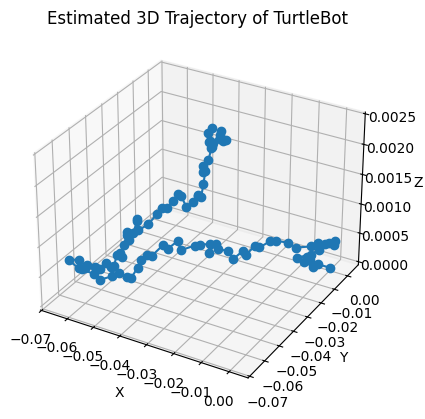

In [14]:
import open3d as o3d
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

# --- CONFIG ---
base_path = r"selected_pcds"  # folder with the 100 .pcd files
file_names = [f"pointcloud_{i:04d}.pcd" for i in range(0, 400, 4)]  # pointcloud_0000.pcd to pointcloud_0396.pcd

# --- Storage ---
global_pcds = []
global_poses = [np.eye(4)]  # first pose is identity
trajectory = [np.array([0, 0, 0])]  # initial position

# --- ICP Parameters ---
voxel_size = 0.05
threshold = 0.1

# --- Helper: run point-to-point ICP ---
def run_icp(source, target, init=np.eye(4), threshold=0.1):
    return o3d.pipelines.registration.registration_icp(
        source, target, threshold, init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )

# --- Process All Consecutive Pairs ---
for i in range(len(file_names) - 1):
    source_file = os.path.join(base_path, file_names[i])
    target_file = os.path.join(base_path, file_names[i+1])

    source = o3d.io.read_point_cloud(source_file).voxel_down_sample(voxel_size)
    target = o3d.io.read_point_cloud(target_file).voxel_down_sample(voxel_size)

    # Estimate normals (optional but helps)
    source.estimate_normals()
    target.estimate_normals()

    # Use identity as initial guess
    icp_result = run_icp(source, target, threshold=threshold)

    # Get last global transformation
    last_pose = global_poses[-1]
    current_pose = icp_result.transformation @ last_pose
    global_poses.append(current_pose)

    # Load original source cloud and transform it
    original = o3d.io.read_point_cloud(source_file)
    original.transform(last_pose)
    global_pcds.append(original)

    # Extract position from transformation
    translation = current_pose[:3, 3]
    trajectory.append(translation)

    print(f"Registered {file_names[i]} -> {file_names[i+1]} | Fitness: {icp_result.fitness:.4f}")

# --- Add the last point cloud ---
final_pcd = o3d.io.read_point_cloud(os.path.join(base_path, file_names[-1]))
final_pcd.transform(global_poses[-1])
global_pcds.append(final_pcd)

# --- Merge all into one registered map ---
combined = global_pcds[0]
for pc in global_pcds[1:]:
    combined += pc

print("Saving merged point cloud to 'registered_map.pcd'")
o3d.io.write_point_cloud("registered_map.pcd", combined)

# --- Save trajectory as CSV ---
print("Saving trajectory to 'trajectory.csv'")
with open("trajectory.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["x", "y", "z"])
    for point in trajectory:
        writer.writerow(point)

# --- Plot trajectory ---
trajectory_np = np.array(trajectory)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory_np[:, 0], trajectory_np[:, 1], trajectory_np[:, 2], marker='o')
ax.set_title("Estimated 3D Trajectory of TurtleBot")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()